In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

#ABCD ray trace function
def ABCD_trace(a,zf, zf_type):
    #a: starting vector a=np.array([[height],[angle]])
    #zf: free space and lens focal lengths
    #zf_type: type of optical element ('z' for free space, 'f' for lens)
    #return matrix of y, z

    #check to make sure the passed arrays match in length
    if np.size(zf) != len(zf_type):
        print("zf and zf_type arrays do not match")
        return None

    trace=np.array([[a[0,0]], [0]])
    for ind in range(len(zf_type)):

        if zf_type[ind] == 'z':
            #free space propagation
            M1 = np.array([[1.0, zf[ind]], [0.0, 1.0]])
            a=M1@a
            #add new point to trace matrix
            y=a[0,0]
            z=trace[1, -1]+zf[ind]
            new_point = np.array([[y], 
                                  [z]])
            # Append column-wise
            trace = np.hstack((trace, new_point))
            
        elif zf_type[ind] == 'f':
            #free space propagation
            M1 = np.array([[1.0, 0.0], [-1/zf[ind], 1.0]])
            a=M1@a
            #Don't append to the trace
            #No ray travel

        else:
            print("Invalid zf_type")
            return None
    return trace

## 1) Key idea: Apertures can block rays

In real optical systems, not all rays from a point reach the image: stops and element rims can clip rays depending on field angle and ray height.

Two primary effects:
- Field of view limitation: apertures restrict which object points can be imaged.
- Image brightness control: apertures restrict the cone of rays reaching the image plane (irradiance/brightness).

We’ll operationalize these ideas by computing which candidate stop creates the smallest apparent cone for an on-axis object point, called aperture stop (AS).  Then imaging that stop to find entrance pupil (EnP) and exit pupil (ExP).


## 2) Definitions you’ll use

### Aperture stop (AS)
The element (a stop or an element rim) that defines the maximum cone of rays from an axial object point that can reach the image.

### Entrance pupil (EnP)
The image of the AS as viewed from object space through all elements before the AS.  
If nothing precedes the AS, EnP coincides with the AS.

### Exit pupil (ExP)
The image of the AS formed by elements after the AS toward image space.  
If nothing follows the AS, ExP coincides with the AS.

### Chief ray and marginal ray
- Chief ray: from an off-axis object point through the axial point of the EnP plane.
- Marginal ray: from an object point through the edge of the EnP.

### Field stop (FS)
- FS: limits FoV via chief rays from off-axis object points.

### Example
A common lens design is the Cooke triplet designed and patented in 1893.

<img src="cooke.png" width="500">

Here is a description of a Cooke lens system: 
- lens 1 has focal length f1=50.93mm
- separation between lens 1 and lens 2 is d12=6.556mm
- lens 2 has focal length f2=-60.85mm
- separation between lens 2 and lens 3 is d23=11.532mm
- focal length of lens 3 is f3=55.16mm

Each lens has a diameter of 20mm.

Let's start by finding the EFL of this lens system.

In [2]:
#Find EFL

f1 = 50.93
f2 = -60.85
f3 = 55.16
d12 = 6.556
d23 = 11.532

# Thin lens: [[1, 0], [-1/f, 1]]
L1 = np.array([[1.0, 0.0], [-1.0/f1, 1.0]])

L2 = np.array([[1.0, 0.0], [-1.0/f2, 1.0]])

L3 = np.array([[1.0, 0.0], [-1.0/f3, 1.0]])

# Free-space translation: [[1, d], [0, 1]]
T12 = np.array([[1.0, d12], [0.0, 1.0]])

T23 = np.array([[1.0, d23], [0.0, 1.0]])

a1=np.array([[1.0], [0.0]])
a2= L3@ T23 @ L2 @ T12 @ L1


print(a2)
print(a2[1][0])

# -1/C is the effective focal length of the system
# (C is also equal to the angle change per height, or the angle of a parallel input ray)

EFL = -1 / a2[1][0]
print("EFL: ", EFL)


[[ 0.80996559 19.33046166]
 [-0.02000033  0.75729688]]
-0.020000328691254704
EFL:  49.99917828536776


The system has one aperture for each of the three lenses.  Find the image of each aperture on the entrance side of the system.

In [3]:
#units of mm
#reference to lens 1
Dlens=20

#Lens 1: 
#  Nothing is to the left of lens 1
D1=Dlens
S_L1=0

#Lens 2:  We are looking backwards from lens 2
#1/d12+1/Si2=1/f1
# Just image lens 2 through lens 1 (find the distance using imaging equation, then magnification)
Si2=1/(1/f1-1/d12)
S_L2=Si2
Mag=-Si2/d12
D2=abs(Mag)*Dlens
print("f1:",f1, "d12:", d12)

#Lens 3:  We are looking backwards from lens 3
#1/d23+1/Si3=1/f2 #from lens 3 to lens 2
Si3=1/(1/f2-1/d23)
Mag1=-Si3/d23

#1/So4+1/Si4=1/f1 #from lens 2 to lens 1
So4=d12-Si3  #object distance to lens 1 from image formed by lens 2
Si4=1/(1/f1-1/So4)
Mag2=-Si4/So4
D3=abs(Mag1)*abs(Mag2)*Dlens
S_L3=Si4  #since we are looking backwards

print("D1: ", D1)
print("Lens 1 aperture: ", S_L1, " This is at Lens 1")

print("D2: ", D2)
print("Lens 2 aperture: ", S_L2, " Negative means that it is to the left of Lens 1")

print("D3: ", D3)
print("Lens 3 aperture: ", S_L3, " Negative means that it is to the left of Lens 1")



f1: 50.93 d12: 6.556
D1:  20
Lens 1 aperture:  0  This is at Lens 1
D2:  22.954883490332175
Lens 2 aperture:  -7.524610808130888  Negative means that it is to the left of Lens 1
D3:  24.692406968121567
Lens 3 aperture:  -23.86578130929635  Negative means that it is to the left of Lens 1


Any ray that is aimed to go through the entrance pupil will make it through.  

The fist lens is trivial.  If a ray hit the first lens then it hits the first lens.

Let's plot two rays aiming to the top of the Lens 2 entrance pupil.

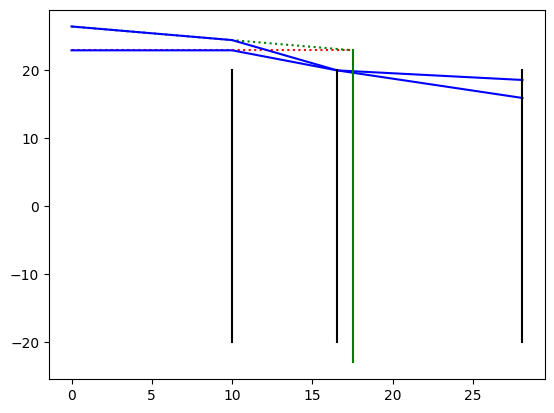

In [4]:
#Entrance pupil corresponding to Lens 2 aperture
#pick two rays that are aimed at the edge of the lens 2 entrance pupil

#(1) Parallel ray 10mm in front of lens system
#aiming to the top of the entrance pupil
a1=np.array([[D2], [0]])
y_aim2a=np.array([D2, D2])  #aiming to the top of the entrance pupil
z_aim2a=np.array([0, 10-S_L2])  #at 10mm infront of lens system
plt.plot(z_aim2a, y_aim2a, 'r:')

zf=np.array([10, f1, d12, f2, d23, f3])  #free space and lens focal lengths
zf_type=['z', 'f', 'z', 'f', 'z', 'f']

trace=ABCD_trace(a1,zf, zf_type)
z1=trace[1,:]
y1=trace[0,:]

#(2) At the same distance of 10mm in front of lens system but angled ray
th=-0.2
h=D2-th*(10-S_L2)
a2=np.array([[h], [th]])
y_aim2b=np.array([h, D2])  #aiming to the top of the entrance pupil
z_aim2b=np.array([0, 10-S_L2])  #at 10mm infront of lens system
plt.plot(z_aim2b, y_aim2b, 'g:')

trace=ABCD_trace(a2,zf, zf_type)
z2=trace[1,:]
y2=trace[0,:]

z_lens1=np.array([10, 10])
y_lens1=np.array([-Dlens, Dlens])

z_lens2=np.array([10+d12, 10+d12])
y_lens2=np.array([-Dlens, Dlens])

z_lens3=np.array([10+d12+d23, 10+d12+d23])
y_lens3=np.array([-Dlens, Dlens])

z_enp2=np.array([10-S_L2, 10-S_L2])
y_enp2=np.array([-D2, D2])


plt.plot(z1, y1, 'b')
plt.plot(z2, y2, 'b')
plt.plot(z_enp2, y_enp2, 'g')
plt.plot(z_lens1, y_lens1, 'k')
plt.plot(z_lens2, y_lens2, 'k') 
plt.plot(z_lens3, y_lens3, 'k') 

plt.show()
      

Let's plot two rays aiming to the top of the Lens 3 entrance pupil.

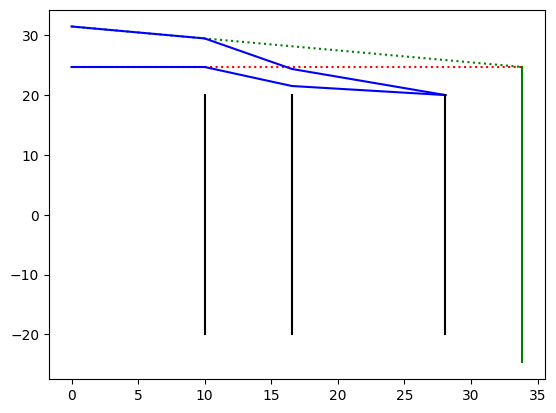

In [5]:
#Entrance pupil corresponding to Lens 3 aperture
#pick two rays that are aimed at the edge of the lens 3 entrance pupil

#(1) Parallel ray 10mm in front of lens system
#aiming to the top of the entrance pupil
a1=np.array([[D3], [0]])
y_aim2a=np.array([D3, D3])  #aiming to the top of the entrance pupil
z_aim2a=np.array([0, 10-S_L3])  #at 10mm infront of lens system
plt.plot(z_aim2a, y_aim2a, 'r:')

zf=np.array([10, f1, d12, f2, d23, f3])  #free space and lens focal lengths
zf_type=['z', 'f', 'z', 'f', 'z', 'f']

trace=ABCD_trace(a1,zf, zf_type)
z1=trace[1,:]
y1=trace[0,:]

#(2) At the same distance of 10mm in front of lens system but angled ray
th=-0.2
h=D3-th*(10-S_L3)
a2=np.array([[h], [th]])
y_aim2b=np.array([h, D3])  #aiming to the top of the entrance pupil
z_aim2b=np.array([0, 10-S_L3])  #at 10mm infront of lens system
plt.plot(z_aim2b, y_aim2b, 'g:')

trace=ABCD_trace(a2,zf, zf_type)
z2=trace[1,:]
y2=trace[0,:]

z_lens1=np.array([10, 10])
y_lens1=np.array([-Dlens, Dlens])

z_lens2=np.array([10+d12, 10+d12])
y_lens2=np.array([-Dlens, Dlens])

z_lens3=np.array([10+d12+d23, 10+d12+d23])
y_lens3=np.array([-Dlens, Dlens])

z_enp2=np.array([10-S_L3, 10-S_L3])
y_enp2=np.array([-D3, D3])


plt.plot(z1, y1, 'b')
plt.plot(z2, y2, 'b')
plt.plot(z_enp2, y_enp2, 'g')
plt.plot(z_lens1, y_lens1, 'k')
plt.plot(z_lens2, y_lens2, 'k') 
plt.plot(z_lens3, y_lens3, 'k') 

plt.show()
      

There are three entrance pupils:
- Lens 1: z=0, D=20mm
- Lens 2: z=7.52mm to right of Lens 1, D=23mm
- Lens 3: z=23.9mm to right of Lens 1, D=23.9mm

In the previous ray traces you can see the following:
- The rays aimed at the entrance pupil for Lens 3 misses Lens 2 and Lens 1
- The rays aimed at the entrance pupil for Lens 2 misses Lens 1

This means that the aperture for Lens 1 is the limiting aperture, and thus is the system aperture stop.

Rather than tracing rays to each entrance pupil, a simpler method is tracing a parallel set of rays through the system to find the limiting aperture.

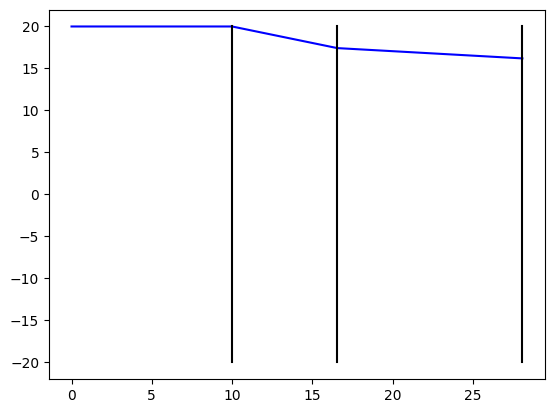

In [6]:
#Assume that the first lens is the limiting aperture

f1 = 50.93
d12 = 6.556
f2 = -60.85
d23 = 11.532
f3 = 55.16


zf=np.array([10, f1, d12, f2, d23, f3])  #free space and lens focal lengths
zf_type=['z', 'f', 'z', 'f', 'z', 'f']

a1=np.array([[Dlens], [0]])

trace=ABCD_trace(a1,zf, zf_type)
z1=trace[1,:]
y1=trace[0,:]

z_lens1=np.array([10, 10])
y_lens1=np.array([-Dlens, Dlens])

z_lens2=np.array([10+d12, 10+d12])
y_lens2=np.array([-Dlens, Dlens])

z_lens3=np.array([10+d12+d23, 10+d12+d23])
y_lens3=np.array([-Dlens, Dlens])

plt.plot(z1, y1, 'b')
plt.plot(z_lens1, y_lens1, 'k')
plt.plot(z_lens2, y_lens2, 'k') 
plt.plot(z_lens3, y_lens3, 'k') 
plt.show()

So, Lens 1 is the limiting aperature and the aperture stop.  

<div style="border:4px solid red">

**HW1:** Camera lens is a double gauss lens that has an effective focal length of EFL=50 mm.  Here is a picture of a Double Gauss lens.

<img src="double_gauss.png" width="500">

Lens focal lengths (thin lenses):
- f₁ = f₄ = +25.000 mm
- f₂ = f₃ = −29.687 mm

(Notice that the double lens is modeled as a single ideal lens.)

Element longitudinal positions (z measured from front surface of L1):
- L1 at z = 0.000 mm
- L2 at z = s = 5.000 mm
- L3 at z = s + g = 10.000 mm
- L4 at z = s + g + s = 15.000 mm

The aperture with a diameter of 5mm is placed in the middle of the lens system.  What is the location of the entrance pupil?  Name variable as hw1.

In [7]:
# HW1: entrance pupil location for the centered stop
f1 = 25.0  # mm
f2 = -29.687  # mm
s = 5.0  # spacing between L1 and L2 in mm
g = 5.0  # spacing between L2 and L3 in mm (symmetry)

z_L1 = 0.0
z_L2 = z_L1 + s
z_aperture = z_L2 + (g / 2.0)  # centered between L2 and L3
D_aperture = 5.0  # mm

# distances from aperture back toward object space
d_L2_to_aperture = z_aperture - z_L2  # 2.5 mm
d_L1_to_L2 = z_L2 - z_L1  # 5 mm

edge_height = D_aperture / 2.0
ray_aperture = np.array([[edge_height], [0.0]])

def thin_lens(f):
    return np.array([[1.0, 0.0], [-1.0 / f, 1.0]])

def translate(dist):
    return np.array([[1.0, dist], [0.0, 1.0]])

# propagate the edge ray back through L2 and L1 (negative translations move left)
system_matrix = (
    thin_lens(f1)
    @ translate(d_L1_to_L2)
    @ thin_lens(f2)
    @ translate(d_L2_to_aperture)
)
ray_exit = system_matrix @ ray_aperture

print(f"Ray at L1 exit: height = {ray_exit[0, 0]:.3f} mm, angle = {ray_exit[1, 0]:.3f} mrad")

# distance needed after L1 for the ray to reach the axis
s_to_axis = -ray_exit[0, 0] / ray_exit[1, 0]
z_lens1_local = -(d_L2_to_aperture + d_L1_to_L2)
z_intersection_local = z_lens1_local + s_to_axis

# convert back to global coordinate system with L1 at z = 0 mm
hw1 = z_intersection_local + z_aperture

print(f"Entrance pupil location relative to L1: {hw1:.3f} mm")

Ray at L1 exit: height = 2.921 mm, angle = -0.033 mrad
Entrance pupil location relative to L1: 89.519 mm


<div style="border:4px solid red">

**HW2:** A Cooke triplet is used as the lens of a camera.
Here is a description of a Cooke lens system: 
- lens 1 has focal length f1=50.93mm
- separation between lens 1 and lens 2 is d12=6.556mm
- lens 2 has focal length f2=-60.85mm
- separation between lens 2 and lens 3 is d23=11.532mm
- focal length of lens 3 is f3=55.16mm

Each lens has a diameter of 20mm. An aperture is placed immediately in front of lens 2.  The aperture diameter is adjusted to create a camera system with an f#=10.  ($f\#=\frac{EFL}{D}$).  What is the diameter of the aperture in units of m?  Use variable hw2.

In [8]:
# HW2: aperture diameter for Cooke triplet with f/10
f1 = 50.93  # mm
f2 = -60.85  # mm
f3 = 55.16  # mm
d12 = 6.556  # mm
d23 = 11.532  # mm

L1 = np.array([[1.0, 0.0], [-1.0 / f1, 1.0]])
L2 = np.array([[1.0, 0.0], [-1.0 / f2, 1.0]])
L3 = np.array([[1.0, 0.0], [-1.0 / f3, 1.0]])
T12 = np.array([[1.0, d12], [0.0, 1.0]])
T23 = np.array([[1.0, d23], [0.0, 1.0]])

M_system = L3 @ T23 @ L2 @ T12 @ L1
C = M_system[1, 0]
EFL_mm = -1.0 / C

f_number = 10.0
aperture_diameter_mm = EFL_mm / f_number
hw2 = aperture_diameter_mm / 1000.0  # convert to meters

print(f"Effective focal length: {EFL_mm:.4f} mm")
print(f"Aperture diameter for f/{f_number:.0f}: {aperture_diameter_mm:.4f} mm")
print(f"hw2 (meters): {hw2:.6f} m")

Effective focal length: 49.9992 mm
Aperture diameter for f/10: 4.9999 mm
hw2 (meters): 0.005000 m


<div style="border:4px solid red">

**HW3:** From the previous lens system, what is the diameter of the entrance pupil?  Use variable name hw3.

In [9]:
# HW3: entrance pupil diameter for Cooke triplet stop at L2
f1 = 50.93  # mm
d12 = 6.556  # mm

# stop diameter (re-use hw2 computed in meters)
D_stop_mm = hw2 * 1000.0

So = d12  # object distance from L1 to the stop plane
Si = 1.0 / (1.0 / f1 - 1.0 / So)
magnification = -Si / So

hw3 = abs(magnification) * D_stop_mm  # entrance pupil diameter in mm

print(f"Stop diameter: {D_stop_mm:.4f} mm")
print(f"Image distance (Si): {Si:.4f} mm")
print(f"Transverse magnification: {magnification:.4f}")
print(f"Entrance pupil diameter (hw3): {hw3:.4f} mm")

Stop diameter: 4.9999 mm
Image distance (Si): -7.5246 mm
Transverse magnification: 1.1477
Entrance pupil diameter (hw3): 5.7386 mm


## Field Stop
The Field Stop is an aperture that affects the field of view rather than the amount of collected light.  For most camera systems the Field Stop is the CCD.  However, a field stop can be placed at an intermediary focal plane.   

**Example:**  A lens system is built with a 50mm focusing objective and a 1:1 relay lens.  The optical system is the following:
- lens 1 focal length f1=20mm
- separation between lens 1 and lens 2 d12=40mm
- lens 2 focal length f2=20mm
- separation between lens 2 and lens 3 d23=2mm
- lens 3 focal length f3=50mm
- separation between lens 3 and CCD d3=50mm

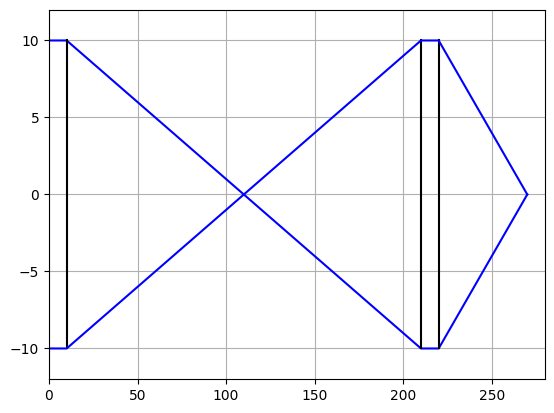

In [10]:
#function to plot lenses
def plt_lens(zf, zf_type, D):
    pos=0
    no_lens=0
    for index, item_type in enumerate(zf_type):
        if item_type=='z':
            pos=pos+zf[index]
            no_lens=no_lens+1
        else:
            if np.isscalar(D):
                plt.plot([pos,pos], [-D,D],'k')
            else:
                plt.plot([pos,pos], [-D[no_lens],D[no_lens]],'k')

#Set up lens system
#ignore lens thicknesses.  These are the glass thickensses only

f1=100
d12=200
f2=100
d23= 10
f3=50
d3=50

#Trace rays through the system

th=00
a1=np.array([[10], [th]])
zf=np.array([10, f1, d12, f2, d23, f3, d3])  #free space and lens focal lengths
zf_type=['z', 'f', 'z', 'f', 'z', 'f', 'z']
trace=ABCD_trace(a1,zf, zf_type)
z1=trace[1,:]
y1=trace[0,:]
plt.plot(z1, y1, 'b')

D=10
plt_lens(zf, zf_type, D)


a2=np.array([[-10], [th]])
zf=np.array([10, f1, d12, f2, d23, f3, d3])  #free space and lens focal lengths
zf_type=['z', 'f', 'z', 'f', 'z', 'f', 'z']

trace=ABCD_trace(a2,zf, zf_type)
z2=trace[1,:]
y2=trace[0,:]
plt.plot(z2, y2, 'b')


D=12
plt.xlim([0, 280])
plt.ylim([-12,12])
plt.grid()
plt.show()


Place an aperture 100mm after the first lens.  Find the entrance pupil for this aperture $\frac{1}{S_i}=\frac{1}{f}-\frac{1}{S_o}$. $S_o=f$, so the entrance pupil doesn't exist.  This aperture is an intermediary focal plane.  So this aperture is a Field Stop not an Aperture Stop.  This aperture changes the Field of View of the system.  If the Field Stop has a width of 6mm and the CCD has a width of 7mm, what is the FOV?  The Field Stop is related to the aperture to the entrance of the optical system.  The EFL of the optical system from the first lens to the Field Stop is f1=100mm.  So $FOV=\frac{H}{f}=\frac{3}{100}$ or $FOV=0.03$. The EFL of the entire system is

In [11]:
a=np.array([[1], [0]])
M1=np.array([[1, 0], [-1/f1, 1]])
M2=np.array([[1, d12], [0, 1]])
M3=np.array([[1, 0], [-1/f2, 1]])
M4=np.array([[1, d23], [0, 1]])
M5=np.array([[1, 0], [-1/f3, 1]])


a1=M5@M4@M3@M2@M1@a
EFL=1/a1[1]
print("EFL: ", EFL)

EFL:  [50.]


So, the Field of View for the CCD is $FOV=\frac{3.5}{50}=0.07$.  This means that a lot of the CCD is dark.  THe ray plot for the rays that hit the edge of the CCD are blocked by the Field Stop.

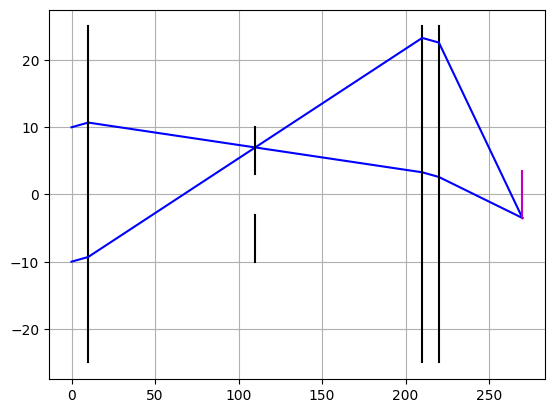

f1:  100


In [12]:
f1=100
d12=200
f2=100
d23=10
f3=50
d3=50

#Trace rays through the system
th=0.07
a1=np.array([[10], [th]])
zf=np.array([10, f1, d12, f2, d23, f3, d3])  #free space and lens focal lengths
zf_type=['z', 'f', 'z', 'f', 'z', 'f', 'z']
trace=ABCD_trace(a1,zf, zf_type)
z1=trace[1,:]
y1=trace[0,:]
plt.plot(z1, y1, 'b')

D=25
plt_lens(zf, zf_type, D)

a2=np.array([[-10], [th]])
zf=np.array([10, f1, d12, f2, d23, f3, d3])  #free space and lens focal lengths
zf_type=['z', 'f', 'z', 'f', 'z', 'f', 'z']

trace=ABCD_trace(a2,zf, zf_type)
z2=trace[1,:]
y2=trace[0,:]
plt.plot(z2, y2, 'b')

#aperture
plt.plot([110, 110], [3,10], 'k')
plt.plot([110, 110], [-3,-10], 'k')

#CCD
plt.plot([270, 270], [-3.5,3.5], 'm')

#plt.xlim([0, 110])
#plt.ylim([-12,12])
plt.grid()
plt.show()

print("f1: ", f1)


The Field of View is dictated by the field stop or $FOV=0.03$.

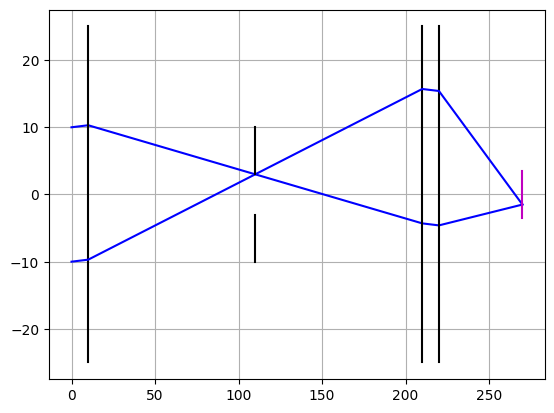

f1:  100


In [13]:
f1=100
d12=200
f2=100
d23=10
f3=50
d3=50

#Trace rays through the system
th=0.03
a1=np.array([[10], [th]])
zf=np.array([10, f1, d12, f2, d23, f3, d3])  #free space and lens focal lengths
zf_type=['z', 'f', 'z', 'f', 'z', 'f', 'z']
trace=ABCD_trace(a1,zf, zf_type)
z1=trace[1,:]
y1=trace[0,:]
plt.plot(z1, y1, 'b')

D=25
plt_lens(zf, zf_type, D)

a2=np.array([[-10], [th]])
zf=np.array([10, f1, d12, f2, d23, f3, d3])  #free space and lens focal lengths
zf_type=['z', 'f', 'z', 'f', 'z', 'f', 'z']

trace=ABCD_trace(a2,zf, zf_type)
z2=trace[1,:]
y2=trace[0,:]
plt.plot(z2, y2, 'b')

#aperture
plt.plot([110, 110], [3,10], 'k')
plt.plot([110, 110], [-3,-10], 'k')

#CCD
plt.plot([270, 270], [-3.5,3.5], 'm')

#plt.xlim([0, 110])
#plt.ylim([-12,12])
plt.grid()
plt.show()

print("f1: ", f1)


<div style="border:4px solid red">

**HW4:** Here is the optical presription of a lens system. All numbers are in units of mm. (Sign convention: Radius R > 0 if center of curvature is to the right) R=0 means a flat surface or infinite radius of curvature.  Model the system using ideal lenses.  Ignore any lens thicknesses.

| Radius R (mm) | Thickness to Next (mm) | Medium / Glass |
|---------------:|----------------------:|----------------|
| 24.345 |2.0 |N-BAF52 |
|-24.345 | 103.5| Air
| +121.7 |2.0 |N-BAF52 |
|-121.7 | 10| Air
|20.24 | 2.0 | N-BK7 |
| -20.24 | 14.0 | Air |
| 12.00 | 2.0 | N-SF11 |
| 3.208 | 19.0 | Air |
| -5.29 | 2.0 | N-F2 |
| 0 | 14.0 | Air |

### Glass Indices of Refraction (d-line, 587.6 nm)

| Glass | Refractive Index (nd) |
|-------|----------------------:|
| N-BK7 | 1.5168 |
| N-SF11 | 1.7847 |
| N-F2 | 1.6200 | 
| N-BAF52 | 1.60863 |

The system has two apertures.  One aperture has a diameter of 1mm and is placed a distance of 100mm to the right of the first lens and the other aperture has a diameter of 5mm and is place at a distance of 160mm from the first lens. A circular CCD is placed at the focus of the system with a diameter of 7mm. What is the position of the entrance pupil relative to the first lens?  Positive means to the left of the first lens and negative means to the right.  Use variable name hw4.

In [14]:
# HW4: entrance pupil location for the two candidate apertures
def lensmaker(R1, R2, n):
    denom = (n - 1.0) * (1.0 / R1 - (0.0 if np.isinf(R2) else 1.0 / R2))
    return 1.0 / denom
lens_focals = [
    lensmaker(24.345, -24.345, 1.60863),
    lensmaker(121.7, -121.7, 1.60863),
    lensmaker(20.24, -20.24, 1.5168),
    lensmaker(12.0, 3.208, 1.7847),
    lensmaker(-5.29, np.inf, 1.6200),
]
lens_positions = np.array([0.0, 103.5, 113.5, 127.5, 146.5])

# Dict of lens data for easier access in tracing function
lens_data = [dict(z=z_pos, f=focal) for z_pos, focal in zip(lens_positions, lens_focals)]

# Just trace the aperture back through the system to find entrance pupil location and diameter
def trace_aperture_to_object_space(aperture_z, aperture_diameter):
    # Trace the aperture backwards through preceding optics to locate its entrance pupil image.
    z_image = aperture_z
    magnification = 1.0
    preceding_lenses = [ld for ld in lens_data if ld["z"] <= aperture_z]
    for lens in reversed(preceding_lenses):
        so = z_image - lens["z"]
        if np.isclose(so, 0.0):
            raise ValueError("Aperture lies on top of a lens; cannot trace.")
        denom = 1.0 / lens["f"] - 1.0 / so
        if np.isclose(denom, 0.0):
            si = np.inf
        else:
            si = 1.0 / denom
        magnification *= -si / so
        z_image = lens["z"] - si
    apparent_diameter = abs(magnification) * aperture_diameter
    return z_image, apparent_diameter


apertures = [
    {"label": "Aperture @100 mm", "z": 100.0, "diameter": 1.0},
    {"label": "Aperture @160 mm", "z": 160.0, "diameter": 5.0},
]

results = []

for ap in apertures:
    z_img, d_app = trace_aperture_to_object_space(ap["z"], ap["diameter"])
    results.append({**ap, "z_image": z_img, "D_app": d_app})

for res in results:
    side = "left" if res["z_image"] < 0 else "right"
    print(f"{res['label']}: entrance image at z = {res['z_image']:.3f} mm ({side} of L1), apparent diameter = {res['D_app']:.3f} mm")

# Find the entrance pupil with the smallest diameter, this will correspond to the limiting aperture stop and thus be the entrance pupil for the system.
aperture_stop = min(results, key=lambda r: r["D_app"])
hw4 = -aperture_stop["z_image"]
print(f"\nAperture stop: {aperture_stop['label']}")
print(f"hw4 = {hw4:.3f} mm (positive means to the left of Lens 1)")

Aperture @100 mm: entrance image at z = -25.000 mm (left of L1), apparent diameter = 0.250 mm
Aperture @160 mm: entrance image at z = -12.780 mm (left of L1), apparent diameter = 0.953 mm

Aperture stop: Aperture @100 mm
hw4 = 25.000 mm (positive means to the left of Lens 1)


<div style="border:4px solid red">

**HW5:** Use the optical system presented in the previous problem. What is the f# of the optical system?  Use variable name hw5.

In [15]:
# HW5: f-number of the multi-element system
def thin_lens_matrix(focal_length):
    return np.array([[1.0, 0.0], [-1.0 / focal_length, 1.0]])
def translate_matrix(distance):
    return np.array([[1.0, distance], [0.0, 1.0]])
if "lens_focals" not in globals():
    raise RuntimeError("Run the HW4 cell to generate lens data before evaluating HW5.")
if "aperture_stop" not in globals():
    raise RuntimeError("Need aperture stop data from HW4 to compute the f-number.")
d12 = 103.5
d23 = 10.0
d34 = 14.0
d45 = 19.0
M_system = (
    thin_lens_matrix(lens_focals[4])
    @ translate_matrix(d45)
    @ thin_lens_matrix(lens_focals[3])
    @ translate_matrix(d34)
    @ thin_lens_matrix(lens_focals[2])
    @ translate_matrix(d23)
    @ thin_lens_matrix(lens_focals[1])
    @ translate_matrix(d12)
    @ thin_lens_matrix(lens_focals[0])
)
C_term = M_system[1, 0]
EFL_system = -1.0 / C_term
entrance_pupil_diameter = aperture_stop["D_app"]
hw5 = EFL_system / entrance_pupil_diameter
print(f"Effective focal length: {EFL_system:.3f} mm")
print(f"Entrance pupil diameter: {entrance_pupil_diameter:.3f} mm")
print(f"hw5 (f-number): f/{hw5:.2f}")

Effective focal length: 4.010 mm
Entrance pupil diameter: 0.250 mm
hw5 (f-number): f/16.04


<div style="border:4px solid red">

**HW6:**  Use the optical system presented in the previous problem. What is the field of view of the optical system?  Use variable name hw6.

In [16]:
# HW6: field of view from CCD diameter
if "EFL_system" not in globals():
    raise RuntimeError("Run HW5 to compute the effective focal length before evaluating HW6.")
ccd_diameter_mm = 7.0
half_height = ccd_diameter_mm / 2.0
hw6 = 2.0 * np.arctan(half_height / EFL_system)
hw6_deg = np.degrees(hw6)
print(f"CCD diameter: {ccd_diameter_mm:.2f} mm (half-height = {half_height:.2f} mm)")
print(f"Effective focal length: {EFL_system:.3f} mm")
print(f"hw6 (full FOV): {hw6:.4f} rad = {hw6_deg:.2f} deg")

CCD diameter: 7.00 mm (half-height = 3.50 mm)
Effective focal length: 4.010 mm
hw6 (full FOV): 1.4351 rad = 82.22 deg
